In [ ]:
!pip install PyDrive

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
download = drive.CreateFile({'id': '1qcEwOgggrg-uP7KN1qZt9ZHhxrQnzlUY'})
download.GetContentFile('DOWNLOAD.tar')

In [ ]:
import tarfile
if not os.path.isdir('dataset'):
  os.mkdir('dataset/')
  my_tar = tarfile.open('DOWNLOAD.tar')
  my_tar.extractall('./dataset') # specify which folder to extract to
  my_tar.close()

## Importing the required libraries

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [ ]:
from keras import regularizers
import IPython.display as ipd

In [ ]:
path = 'dataset/AudioEmotion'
mylist= os.listdir(path)

In [ ]:
type(mylist), len(mylist)

(list, 1440)

In [ ]:
print(mylist[0])

03-01-07-02-02-01-20.wav


In [ ]:
print(mylist[0][6:8])

07


## Plotting the audio file's waveform and its spectrogram

In [ ]:
import pandas as pd
import librosa
import glob 
def waveform(path, mylist): 
  data, sampling_rate = librosa.load(path+ '/'+ mylist[1])
  print(mylist[1])
  % pylab inline
  plt.figure(figsize=(15, 5))
  librosa.display.waveplot(data, sr=sampling_rate)
  return data, sampling_rate

## Setting the labels

In [ ]:
feeling_list=[]
for item in mylist:
  if item[15:17]=='01':
      if item[6:8]=='03' and int(item[-5:-4])%2==0:
          feeling_list.append('female_happy')
      elif item[6:8]=='03' and int(item[-5:-4])%2==1:
          feeling_list.append('male_happy')
      elif item[6:8]=='05' and int(item[-5:-4])%2==0:
          feeling_list.append('female_angry')
      elif item[6:8]=='05' and int(item[-5:-4])%2==1:
          feeling_list.append('male_angry')
      elif item[6:8]=='06' and int(item[-5:-4])%2==0:
          feeling_list.append('female_fearful')
      elif item[6:8]=='06' and int(item[-5:-4])%2==1:
          feeling_list.append('male_fearful')


In [ ]:
labels = pd.DataFrame(feeling_list)

In [ ]:
labels[:10]

,0
0,male_fearful
1,female_happy
2,male_fearful
3,female_fearful
4,female_fearful
5,female_happy
6,female_angry
7,male_fearful
8,female_angry
9,female_happy


# Augmentation methods

03-01-04-02-01-01-24.wav
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shuffle', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


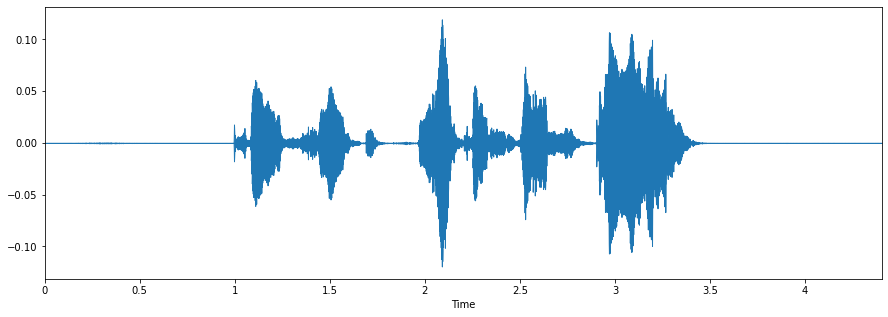

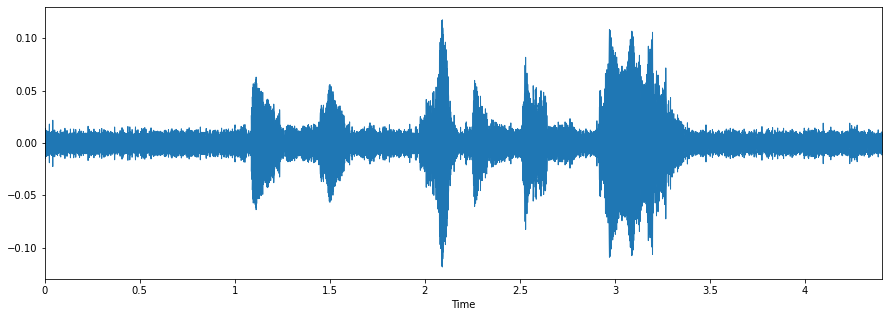

In [ ]:
def noise(data):
    """
    Adding White Noise.
    """
    # https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*1000)  #default at 500
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound. Note that this expands the dataset slightly
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=-0.5 ,high=7)  # default low = 1.5, high = 3
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data


def example(path, mylist):
  #before
  data, sampling_rate = waveform(path, mylist)

  #after
  x = noise(data)
  plt.figure(figsize=(15, 5))
  librosa.display.waveplot(x, sr=sampling_rate)
  return x

x = example(path,mylist)
ipd.Audio(x, rate=sampling_rate)

## Getting the features of audio files using librosa

In [ ]:
df = pd.DataFrame(columns=['feature'])
df_noise = pd.DataFrame(columns=['feature'])
df_shift = pd.DataFrame(columns=['feature'])
df_speedpitch = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
  if mylist[index][15:17]=='01' and (mylist[index][6:8]=='03' or mylist[index][6:8]=='05' or mylist[index][6:8]=='06'):
      X, sample_rate = librosa.load( path + '/' +y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
      sample_rate = np.array(sample_rate)

      mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
      feature = mfccs
      df.loc[bookmark] = [feature]      

      # noise
      aug = noise(X)
      aug = np.mean(librosa.feature.mfcc(y=aug, sr=np.array(sample_rate), 
                                      n_mfcc=13),    
                    axis=0)
      df_noise.loc[bookmark] = [aug]

      # shift
      aug = shift(X)
      aug = np.mean(librosa.feature.mfcc(y=aug, sr=np.array(sample_rate), 
                                      n_mfcc=13),    
                    axis=0)
      df_shift.loc[bookmark] = [aug]

      # speed speed and pitch
      aug = speedNpitch(X)
      aug = np.mean(librosa.feature.mfcc(y=aug, 
                                      sr=np.array(sample_rate), 
                                      n_mfcc=13),    
                    axis=0)
      df_speedpitch.loc[bookmark] = [aug]
      bookmark=bookmark+1    


In [ ]:
df.shape, df_noise.shape, df_shift.shape, df_speedpitch.shape

((288, 1), (288, 1), (288, 1), (288, 1))

In [ ]:
df3 = pd.DataFrame(df['feature'].values.tolist())
df4 = pd.DataFrame(df_noise['feature'].values.tolist())
df5 = pd.DataFrame(df_shift['feature'].values.tolist())
df6 = pd.DataFrame(df_speedpitch['feature'].values.tolist())

In [ ]:
df3 = pd.concat([df3,labels], axis=1)
df4 = pd.concat([df4,labels], axis=1)
df5 = pd.concat([df5,labels], axis=1)
df6 = pd.concat([df6,labels], axis=1)

In [ ]:
dfnew = pd.concat([df3,df4,df5,df6], axis=0)

In [ ]:
dfnew.shape

(1152, 217)

In [ ]:
rnewdf = dfnew.rename(index=str, columns={"0": "label"})

In [ ]:
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,0
0,-53.373125,-52.743305,-53.675258,-51.377994,-48.809563,-49.030382,-50.372866,-53.675896,-54.552370,-53.142108,-53.610586,-55.433940,-57.951387,-54.885418,-51.634623,-50.901597,-49.966008,-50.504414,-52.608671,-51.308768,-48.925428,-49.034593,-50.118049,-48.654762,-47.483778,-49.641545,-50.835456,-50.754202,-50.612879,-49.287514,-49.468941,-50.591536,-49.770078,-51.247858,-51.414254,-49.884619,-51.044693,-50.304900,-47.951085,-47.445263,...,-35.459623,-32.315050,-29.291569,-28.605242,-30.595629,-30.725341,-29.119151,-29.952035,-32.545674,-31.675500,-30.063373,-31.051413,-34.074874,-32.301860,-31.661670,-32.654722,-35.001554,-33.362010,-33.474114,-36.106173,-37.089322,-37.812294,-37.449476,-36.287519,-37.229506,-39.164082,-40.187381,-40.446094,-41.107143,-39.674765,-39.598808,-40.024078,-40.442644,-41.814178,-44.120571,-45.215545,-43.757561,-43.507504,-44.861471,male_fearful
1,-40.588497,-40.581083,-40.605576,-40.649172,-40.645645,-40.654913,-40.655991,-40.645635,-40.632103,-40.652580,-40.652711,-40.656857,-40.656176,-40.669192,-40.646030,-40.656857,-40.656857,-40.656857,-40.656857,-40.656857,-40.656857,-40.656857,-40.656857,-40.656857,-40.656857,-40.656857,-40.656857,-40.656857,-40.656857,-40.656857,-40.656857,-40.656857,-40.656857,-40.656857,-40.656857,-40.656857,-40.656857,-40.656857,-40.656857,-40.656857,...,-39.267956,-39.279096,-40.219228,-39.763208,-35.338837,-33.506720,-33.820782,-32.947563,-32.942071,-31.171246,-27.251716,-25.708673,-26.526199,-26.733637,-24.249391,-24.166803,-24.417042,-24.905190,-27.649683,-26.303985,-27.692664,-29.205236,-31.340964,-32.567898,-34.303233,-36.053783,-35.522478,-33.475985,-35.067771,-38.336985,-37.957702,-37.451445,-39.119533,-39.735301,-40.298764,-40.656857,-40.656857,-40.656857,-40.656857,female_happy
2,-47.856729,-48.079506,-48.079506,-48.079506,-48.079506,-48.079506,-48.079506,-48.065502,-46.886923,-46.552115,-46.202143,-46.353102,-46.784102,-47.512411,-48.079506,-48.079506,-47.803682,-47.392258,-47.682798,-47.222691,-46.765750,-46.348929,-45.311986,-44.429412,-43.897067,-40.478599,-39.379283,-41.600548,-40.473807,-39.747981,-39.458963,-37.611030,-36.810917,-37.281745,-36.789317,-36.234093,-38.656068,-31.190791,-26.801197,-29.376465,...,-43.097583,-44.219571,-45.986482,-46.751549,-46.989424,-45.979471,-45.456215,-44.676370,-43.411689,-43.437161,-42.804343,-43.789047,-45.581197,-45.397079,-43.168655,-42.127129,-42.718987,-42.022589,-41.981866,-43.603902,-42.581427,-42.117790,-43.360806,-43.185968,-43.525258,-44.502056,-43.654406,-42.871340,-44.365682,-44.597066,-44.694870,-43.914891,-42.525380,-42.155072,-42.449937,-41.510247,-41.542316,-42.011152,-42.341417,male_fearful
3,-45.194876,-45.194876,-45.194876,-45.194876,-45.194876,-45.194876,-45.194876,-45.194876,-45.194876,-45.194876,-45.194876,-45.194876,-45.194876,-45.194876,-45.194876,-45.194876,-45.305177,-45.445062,-45.450490,-45.429966,-45.487209,-45.361540,-45.348959,-45.318977,-45.130323,-44.937976,-44.650962,-45.014815,-45.102365,-45.041602,-44.596257,-44.079145,-43.415673,-43.737166,-44.568059,-45.210960,-44.166849,-45.362494,-44.816844,-45.194876,...,-41.510635,-41.806051,-42.416428,-42.715311,-43.187458,-43.669168,-42.022504,-41.893612,-44.528469,-44.193292,-43.422327,-44.390655,-44.099319,-43.893988,-44.518114,-45.110769,-43.781989,-43.707636,-44.382761,-45.408291,-44.502393,-44.570356,-43.982556,-43.562586,-43.564975,-44.825316,-44.864170,-44.171360,-44.410120,-45.120444,-45.666244,-45.259188,-45.147653,-45.233620,-45.194876,-45.194876,-45.194876,-45.194876,-45.194876,female_fearful
4,-45.108556,-45.108556,-45.108556,-45.093925,-44.990189,-45.020619,-44.904684,-44.905991,-45.009564,-44.972138,-44.891819,-45.026939,-45.107946,-45.146765,-44.789559,-44.53

In [ ]:
from sklearn.utils import shuffle
rnewdf = shuffle(dfnew)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,0
239,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.560599,-50.568135,-51.168701,-48.404094,-35.341700,-28.789877,-26.538153,-27.275230,-27.422155,-27.058127,...,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,-53.559953,female_happy
265,-53.319878,-53.395692,-54.543472,-56.423225,-55.133444,-51.574752,-50.676673,-51.625015,-51.292594,-51.785742,-51.483418,-52.164030,-53.570282,-54.832341,-54.068493,-51.740254,-52.950015,-55.235429,-52.688478,-50.953217,-53.137566,-54.946650,-55.044412,-52.474392,-52.454807,-50.530002,-49.015169,-53.027031,-57.381679,-54.230769,-52.940889,-56.198901,-55.797139,-54.166714,-54.871044,-54.126752,-52.096192,-50.290046,-49.705998,-53.250414,...,-41.134326,-41.610984,-42.745104,-43.702357,-44.690792,-44.849658,-45.341891,-46.520060,-45.997686,-47.845020,-50.922694,-52.237424,-52.420224,-54.121332,-55.296978,-52.201006,-47.858385,-46.613169,-49.822124,-50.585378,-50.970112,-52.237700,-52.361050,-51.644063,-48.307549,-47.148874,-47.846803,-47.756464,-47.642285,-49.851958,-50.315647,-48.320723,-50.018037,-53.912568,-54.270282,-55.156772,-52.958824,-52.878677,-57.001627,male_angry
286,-49.858596,-49.858596,-49.858596,-49.858596,-49.858596,-49.858596,-49.858596,-49.858596,-49.858596,-49.858596,-49.858596,-49.858596,-49.858596,-49.858596,-49.858596,-49.858596,-49.858596,-49.858596,-49.598976,-49.124032,-49.490438,-48.905454,-48.551212,-48.071695,-47.387071,-46.572367,-43.760547,-39.814582,-34.838567,-33.453634,-35.892420,-36.316947,-35.769780,-35.811970,-36.967901,-40.437759,-42.950955,-37.595437,-37.338498,-38.987794,...,-24.798455,-25.365977,-25.426485,-24.797753,-23.692109,-23.260349,-23.773284,-22.343335,-21.658179,-22.384189,-22.573093,-21.034275,-20.248616,-20.546171,-21.131845,-21.934251,-23.729230,-23.888231,-23.257833,-22.516775,-23.987928,-26.018106,-26.241064,-25.753294,-27.448389,-28.698538,-32.181696,-31.737552,-31.649510,-31.508227,-32.465190,-32.426259,-33.192696,-36.206382,-36.321285,-36.793291,-36.016966,-36.202610,-38.077489,female_angry
185,-39.070377,-38.467503,-38.604761,-37.403119,-38.232317,-39.630853,-40.394924,-39.535836,-38.766484,-38.510285,-36.306312,-34.550015,-33.305548,-31.898829,-34.589394,-34.576314,-33.618512,-32.812567,-32.087413,-32.499109,-34.288454,-34.041778,-35.260874,-37.658965,-36.676399,-36.066630,-35.360104,-34.985505,-37.930837,-38.890981,-41.374666,-42.893534,-41.960385,-38.769787,-38.640185,-35.559914,-33.904866,-32.572963,-29.607107,-24.556787,...,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,-43.786987,female_fearful
258,-50.978940,-49.829755,-48.447375,-47.013320,-48.143941,-48.876457,-50.741082,-52.391192,-53.455372,-50.930146,-49.664606,-48.017638,-48.636193,-52.637962,-49.64055

In [ ]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [ ]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [ ]:
len(train)/(len(train)+len(test)), len(test), 

(0.7960069444444444, 235)

In [ ]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,0
44,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-67.632371,-62.055786,-57.698317,-56.865492,-56.742607,-57.307465,-57.352780,-57.975719,-59.561800,-62.530901,-65.433586,-66.386941,-65.436996,-65.830422,-65.253021,-65.831904,-63.621389,-62.929262,-63.528608,-64.174038,-54.980276,-48.364815,-42.576676,-31.555611,-28.806317,-29.259411,-30.852256,-33.917816,-30.867140,-31.221589,...,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,-69.785109,male_happy
209,-37.345887,-38.999232,-40.050124,-42.803423,-45.308376,-44.391581,-45.124384,-44.985467,-44.625975,-48.205897,-50.489825,-50.489825,-50.489825,-50.489825,-50.489825,-50.489825,-50.489825,-50.489825,-50.489825,-50.489825,-50.489825,-50.487623,-50.279153,-50.393913,-50.388285,-50.191565,-49.920179,-49.741238,-49.861129,-49.535725,-49.675490,-50.420564,-50.075629,-49.187067,-48.546981,-49.162287,-49.928306,-49.610581,-49.529731,-50.481820,...,-18.866873,-22.747819,-24.067346,-26.213361,-26.206143,-25.500622,-25.439709,-26.417920,-28.342015,-28.711284,-29.392600,-27.204211,-26.226498,-26.101606,-23.692180,-22.655490,-22.758937,-22.079244,-21.480117,-19.947759,-20.713816,-19.613965,-19.001611,-20.269284,-20.583949,-20.634389,-22.259262,-24.100951,-24.731564,-25.245903,-27.044249,-29.174270,-32.952969,-33.207322,-31.633595,-35.125886,-37.137589,-35.377595,-37.136609,male_happy
225,-30.261537,-30.081709,-32.200825,-31.434191,-32.481508,-33.362381,-30.964608,-32.761922,-33.040278,-32.410513,-33.065685,-31.062674,-31.127651,-30.152588,-30.345111,-31.003068,-33.315900,-31.263066,-29.733719,-29.817165,-31.458932,-32.605163,-33.048971,-32.710926,-32.313695,-32.302580,-33.759160,-34.241784,-31.661125,-31.799216,-30.005030,-31.465849,-30.101238,-30.232886,-30.948420,-30.073918,-30.130982,-30.967396,-31.070736,-31.189630,...,-31.784858,-33.279383,-33.150308,-31.012930,-31.279710,-32.238159,-33.887598,-34.851362,-30.884535,-30.190698,-29.296087,-29.720304,-30.312587,-32.394422,-34.563416,-33.138374,-32.195659,-31.649201,-33.207814,-31.626437,-29.137210,-30.238374,-31.160267,-33.126459,-34.445838,-32.320005,-31.086857,-31.763732,-32.563043,-35.100513,-32.079256,-30.557600,-32.320192,-33.181205,-33.906029,-33.226779,-34.083342,-30.908416,-31.324461,male_fearful
241,-48.469571,-48.375572,-48.274745,-48.311722,-48.311722,-48.311722,-48.311722,-48.311722,-48.311722,-48.311722,-48.311722,-48.311722,-48.311722,-48.311722,-48.304630,-48.311722,-48.311722,-48.311722,-48.311722,-48.311722,-48.311722,-48.311722,-48.311722,-48.311722,-48.311722,-48.311722,-48.276386,-48.199867,-48.311722,-48.311722,-48.311722,-48.311722,-46.504806,-40.390321,-32.121438,-27.069192,-25.899912,-26.561270,-30.093184,-31.875535,...,-29.915245,-29.611730,-31.007865,-32.709392,-26.499693,-23.711183,-20.023056,-19.590953,-21.315264,-21.486099,-18.576449,-16.047498,-14.913548,-17.355306,-18.572236,-19.706982,-20.827718,-19.844660,-19.493344,-19.594021,-19.594095,-20.779290,-22.392643,-22.622855,-22.790337,-23.551882,-23.731406,-24.050365,-23.055583,-21.258075,-13.770276,-14.563169,-28.059671,-47.778317,-47.066570,-48.343306,-48.731097,-48.345958,-48.225276,male_happy
220,-46.882402,-46.882402,-46.882402,-46.882402,-46.882402,-46.882402,-46.882402,-46.882402,-46.882402,-46.882402,-46.882402,-46.882402,-46.882402,-46.882402,-46.873311,-46.7

In [ ]:
trainfeatures = train.iloc[:, :-1]

In [ ]:
trainlabel = train.iloc[:, -1:]

In [ ]:
testfeatures = test.iloc[:, :-1]

In [ ]:
testlabel = test.iloc[:, -1:]

In [ ]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
y_train

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
X_train.shape

(917, 216)

## Padding sequence for CNN model

In [ ]:
print('Pad sequences')
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

Pad sequences


In [ ]:
model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(6))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 216, 128)          768       
_________________________________________________________________
activation_35 (Activation)   (None, 216, 128)          0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 216, 128)          82048     
_________________________________________________________________
activation_36 (Activation)   (None, 216, 128)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 27, 128)          

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [ ]:
checkpoint_dir = 'saved_models/'
cnnhistory = model.fit(
    x_traincnn, y_train, batch_size=32, epochs=1009, validation_data=(x_testcnn, y_test),
    # callbacks = [
    #              tf.keras.callbacks.ModelCheckpoint(
    #                  os.path.join(checkpoint_dir, 'epochs_{epoch:04d}_vacc_{val_accuracy:.4f}.h5'),
    #                  monitor = 'val_accuracy',
    #                  save_weights_only = False,
    #                  save_best_only = True
    #              )
    # ]
)

## Plotting the accuracy and loss graph

In [ ]:
model = tf.keras.models.load_model('saved_models/epochs_0964_vacc_0.7018.h5')

In [ ]:
model.evaluate(x_testcnn, y_test)

8/8 [==============================] - 0s 29ms/step - loss: 0.9247 - accuracy: 0.6979


[0.9246569275856018, 0.6978723406791687]

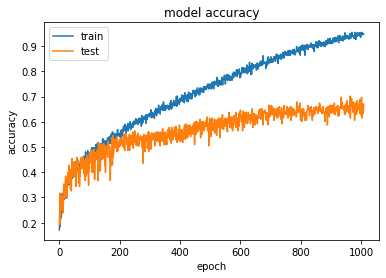

In [ ]:
#sigmoid
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

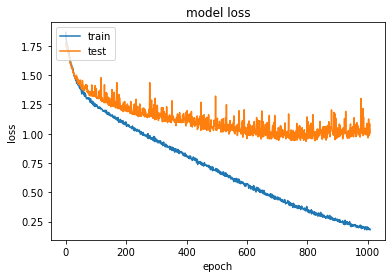

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [ ]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/Emotion_Voice_Detection_Model.h5 


# Saving the Label Binarizer

In [ ]:
import pickle

saved_lb = open('saved_lb.sav', 'wb')
pickle.dump(lb , saved_lb)
saved_lb.close()

#lb = pickle.load(open( 'saved_lb.sav' , 'rb' ))

## Predicting emotions on the test data

In [ ]:
preds = model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

8/8 [==============================] - 0s 30ms/step


In [ ]:
preds

array([[7.03582019e-02, 3.25984001e-01, 1.52948022e-01, 4.30919796e-01,
        1.43420370e-02, 5.44796512e-03],
       [9.96147156e-01, 5.04361291e-04, 2.65371590e-03, 9.35500429e-06,
        1.83902121e-05, 6.67026674e-04],
       [3.50687653e-03, 4.70137596e-02, 2.39841384e-03, 8.16832483e-03,
        8.88879001e-01, 5.00336699e-02],
       ...,
       [1.66942235e-02, 1.80001169e-01, 8.00284505e-01, 8.82990480e-06,
        3.62575229e-04, 2.64852820e-03],
       [4.41954910e-07, 4.24366320e-08, 8.27408803e-06, 9.92388427e-01,
        7.20679108e-03, 3.95956798e-04],
       [4.21369597e-02, 4.27081697e-02, 3.69418822e-02, 2.31152354e-03,
        1.42469285e-02, 8.61654520e-01]], dtype=float32)

In [ ]:
preds1=preds.argmax(axis=1)

In [ ]:
preds1

array([3, 0, 4, 4, 1, 4, 1, 1, 5, 1, 2, 4, 2, 4, 4, 4, 4, 5, 4, 2, 3, 1,
       5, 0, 5, 2, 0, 5, 0, 3, 3, 2, 1, 4, 1, 5, 4, 1, 2, 0, 3, 2, 2, 2,
       4, 5, 4, 0, 2, 5, 1, 3, 2, 4, 4, 2, 4, 5, 3, 2, 4, 3, 5, 0, 3, 2,
       0, 1, 0, 2, 5, 1, 5, 1, 2, 3, 5, 0, 3, 1, 5, 1, 0, 0, 1, 4, 5, 2,
       0, 5, 5, 4, 1, 0, 1, 2, 1, 3, 2, 3, 2, 1, 0, 4, 0, 3, 3, 0, 1, 0,
       3, 5, 3, 1, 5, 5, 0, 4, 3, 4, 2, 0, 3, 5, 1, 5, 0, 1, 5, 5, 2, 3,
       2, 0, 1, 3, 1, 2, 2, 0, 0, 3, 2, 2, 4, 2, 2, 1, 4, 1, 1, 5, 5, 1,
       5, 1, 2, 1, 1, 0, 1, 5, 2, 1, 4, 5, 1, 1, 3, 0, 5, 3, 1, 2, 3, 3,
       1, 4, 4, 4, 0, 4, 1, 3, 4, 1, 0, 5, 4, 4, 5, 0, 5, 2, 3, 4, 2, 4,
       0, 4, 3, 1, 5, 1, 5, 4, 5, 5, 1, 2, 3, 0, 3, 4, 0, 4, 3, 4, 4, 0,
       4, 1, 3, 3, 3, 3, 5, 2, 1, 2, 1, 3, 2, 3, 5])

In [ ]:
abc = preds1.astype(int).flatten()

In [ ]:
predictions = (lb.inverse_transform((abc)))

In [ ]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_angry
1,female_angry
2,male_fearful
3,male_fearful
4,female_fearful
5,male_fearful
6,female_fearful
7,female_fearful
8,male_happy
9,female_fearful


In [ ]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [ ]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,female_fearful
1,female_angry
2,male_fearful
3,male_fearful
4,female_fearful
5,male_fearful
6,female_happy
7,male_fearful
8,male_happy
9,female_fearful


In [ ]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [ ]:
finaldf[170:180]

,actualvalues,predictedvalues
170,male_happy,male_happy
171,male_angry,male_angry
172,female_fearful,female_fearful
173,female_happy,female_happy
174,male_angry,male_angry
175,male_angry,male_angry
176,female_fearful,female_fearful
177,male_fearful,male_fearful
178,male_fearful,male_fearful
179,male_fearful,male_fearful


In [ ]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,35
female_fearful,38
female_happy,44
male_angry,36
male_fearful,41
male_happy,41


In [ ]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,33
female_fearful,46
female_happy,38
male_angry,38
male_fearful,41
male_happy,39


In [ ]:
cnnhistory.params

{'epochs': 1009, 'steps': 30, 'verbose': 1}

In [ ]:
finaldf.to_csv('Predictions.csv', index=False)

# Sample Voice Prediction

In [ ]:
def random( voice ):
  X, sample_rate = librosa.load( voice , res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
  sample_rate = np.array(sample_rate)
  mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
  feature = mfccs
  return feature

voice = 'sample_voice.wav'
feature = random(voice)
x_t = feature.reshape(1,x.shape[0],1)

#load model

pred = model.predict(x_t)
pred = np.argmax(pred)
pred = np.reshape(pred, (1,))

#load label binarizer instance
lb = pickle.load(open( 'saved_lb.sav' , 'rb' ))
emotion = lb.inverse_transform(pred)[0]

data, sampling_rate = librosa.load(voice)
ipd.Audio(data, rate=sampling_rate)

In [ ]:
print(emotion)


female_happy


In [ ]:
type(pred)

numpy.ndarray